<p align="center">
  <b>VELIB Data Science</b><br>
  Name: Victor Hugo Ribeiro Leite Da Silva<br>
  E-mail: victorhugo.ribeiro@telecom-paris.fr<br>
  Phone: +33 07 49 85 76 43
</p>

### Summary of my approach

In this analysis, I explore the VELIB dataset through data cleaning, feature engineering, and modeling stages.  
The goal is to uncover insights about bike usage patterns and develop predictive models that optimize resource allocation.

- Data Analysis  
- Data Cleaning  
- Feature Engineering  
- Modeling


## Importing Libraries and Datasets

### Libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point

import geopandas as gpd
import requests
from datetime import datetime, timedelta
import time
import os



pd.set_option('display.max_columns', None) #Show all columns

### Datasets

In [7]:
df = pd.read_csv( 'velib-disponibilite-en-temps-reel.csv', sep = ';')
df.head()

,Identifiant station,Nom station,Station en fonctionnement,Capacité de la station,Nombre bornettes libres,Nombre total vélos disponibles,Vélos mécaniques disponibles,Vélos électriques disponibles,Borne de paiement disponible,Retour vélib possible,Actualisation de la donnée,Coordonnées géographiques,Nom communes équipées,Code INSEE communes équipées,station_opening_hours
0,16107,Benjamin Godard - Victor Hugo,OUI,35,29,5,1,4,OUI,OUI,2025-10-18T18:37:02+02:00,"48.865983, 2.275725",Paris,75056,NaN
1,32304,Charcot - Benfleet,OUI,28,25,1,0,1,OUI,OUI,2025-10-18T18:38:01+02:00,"48.878370277021, 2.440523876268",Romainville,93063,NaN
2,40001,Hôpital Mondor,OUI,28,9,18,10,8,OUI,OUI,2025-10-18T18:40:10+02:00,"48.798922410229, 2.4537451531298",Créteil,94028,NaN
3,14111,Cassini - Denfert-Rochereau,OUI,25,21,2,1,1,OUI,OUI,2025-10-18T18:39:09+02:00,"48.837525839067, 2.3360354080796",Paris,75056,NaN
4,9020,Toudouze - Clauzel,OUI,21,18,3,1,2,OUI,OUI,2025-10-18T18:36:44+02:00,"48.87929591733507, 2.3373600840568547",Paris,75056,NaN


### Data Analysis

Getting the main info to train the data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495 entries, 0 to 1494
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Identifiant station             1495 non-null   int64  
 1   Nom station                     1495 non-null   object 
 2   Station en fonctionnement       1495 non-null   object 
 3   Capacité de la station          1495 non-null   int64  
 4   Nombre bornettes libres         1495 non-null   int64  
 5   Nombre total vélos disponibles  1495 non-null   int64  
 6   Vélos mécaniques disponibles    1495 non-null   int64  
 7   Vélos électriques disponibles   1495 non-null   int64  
 8   Borne de paiement disponible    1495 non-null   object 
 9   Retour vélib possible           1495 non-null   object 
 10  Actualisation de la donnée      1495 non-null   object 
 11  Coordonnées géographiques       1495 non-null   object 
 12  Nom communes équipées           14

Checking number of NA on the dataset

In [9]:
df.isna().sum()

Identifiant station                  0
Nom station                          0
Station en fonctionnement            0
Capacité de la station               0
Nombre bornettes libres              0
Nombre total vélos disponibles       0
Vélos mécaniques disponibles         0
Vélos électriques disponibles        0
Borne de paiement disponible         0
Retour vélib possible                0
Actualisation de la donnée           0
Coordonnées géographiques            0
Nom communes équipées                0
Code INSEE communes équipées         0
station_opening_hours             1495
dtype: int64

Since the column 'station_opening_hours' has all values NA, i will consider that ALL stations are always open. Thus, i will drop this column

In [10]:
df = df.drop(['station_opening_hours'], axis = 1) 

--- 

### Before making any analysis, it is important to understand the two stations i want to work on

Since i always do the same 10km traject by bike and need these 2 stations to be free, i will load paris map and show the exact location of them using the coordinates of velib dataset

In [11]:
# Load Paris map shapefile or GeoJSON
paris_map = gpd.read_file("arrondissements/arrondissements.shp")
paris_map.plot(figsize=(10, 10), edgecolor='black', color='lightblue')

DataSourceError: arrondissements/arrondissements.shp: No such file or directory

/var/folders/tz/tl_w5k6s62vcg00cl2mjjbtc0000gn/T/ipykernel_94876/190097045.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  paris_map.centroid.plot(ax=ax, color='red', marker='o')


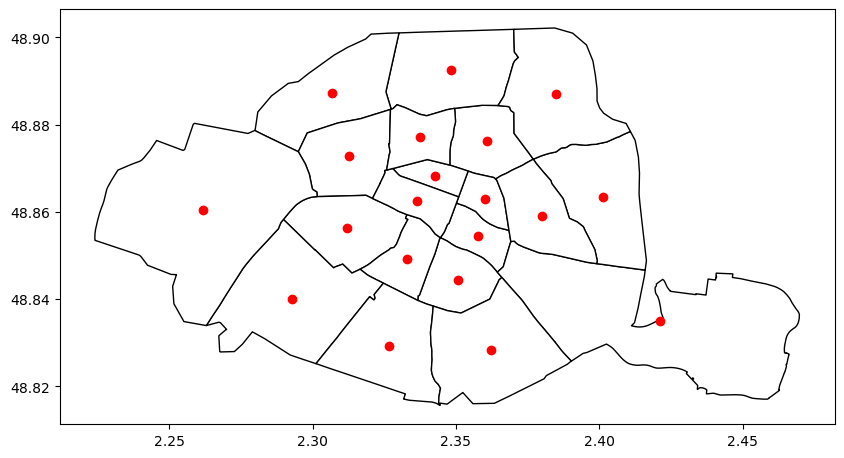

In [ ]:
# all the arrondissements of Paris

fig, ax = plt.subplots(figsize=(10, 10))
paris_map.plot(ax=ax, color='white', edgecolor='black')
paris_map.centroid.plot(ax=ax, color='red', marker='o')
plt.show()

### By looking on the official website i can verify that the 2 stations i use the most are:

- Jourdan - Monticelli 
- Porte Dauphine

These are the stations I use everyday to leave cite universitaire and get to Dauphine. So since they are the most importants for me, i will use them as a base and take their information from my dataset

In [ ]:
# Geographic Coordenates

stations = df[  df['Nom station'].isin(['Porte Dauphine', 'Jourdan - Monticelli'])  ]
stations['Coordonnées géographiques']


770                  48.822032, 2.329095
1089    48.871139344351, 2.2749781616017
Name: Coordonnées géographiques, dtype: object

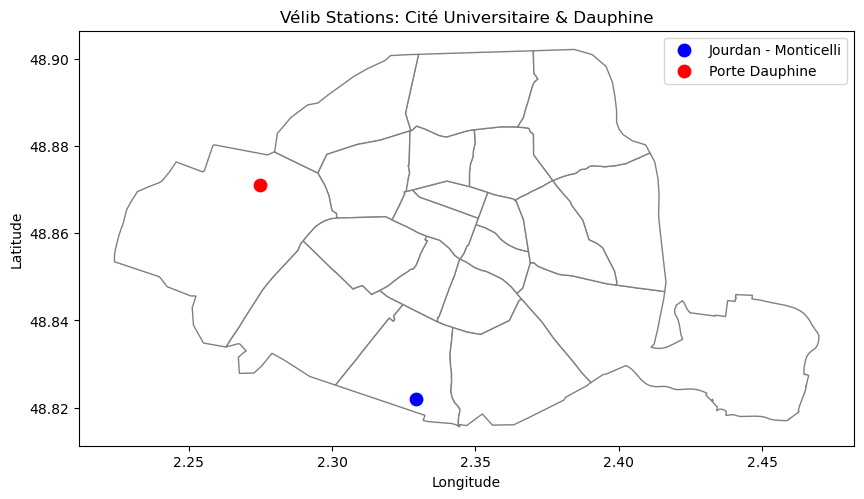

In [ ]:
# Putting these points on the map

data = {
    'station': ['Jourdan - Monticelli', 'Porte Dauphine'],
    'lat': [48.822032, 48.871139],
    'lon': [2.329095, 2.274978],
    'color': ['blue', 'red']  
}

# Creates GeoDataFrame
stations = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
paris_map.to_crs(epsg=4326).plot(ax=ax, color='white', edgecolor='gray')

# Add points
for i, row in stations.iterrows():
    ax.scatter(row.geometry.x, row.geometry.y, color=row.color, s=80, label=row.station)

# Config 
ax.legend()
ax.set_title("Vélib Stations: Cité Universitaire & Dauphine")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

---

## The use of velib in Paris

Before giving a special attention to the two stations, i want to analyse the general use of velib

1. How do usage patterns vary across time (hours, days, or districts), and can we identify clusters of stations with similar temporal dynamics?
2. What are the regions of highest demand ? 
3. For every station , what is the distribution of bikes ? We usually have more eletric or mechanic ?


### Working with the new dataset got from my API

In [14]:
df = pd.read_csv('velib_history.csv')

df.head()

/var/folders/tz/tl_w5k6s62vcg00cl2mjjbtc0000gn/T/ipykernel_4312/754090637.py:1: DtypeWarning: Columns (2,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('velib_history.csv')


,name,stationcode,ebike,mechanical,coordonnees_geo,duedate,numbikesavailable,numdocksavailable,capacity,is_renting,is_installed,nom_arrondissement_communes,is_returning,code_insee_commune,timestamp_coleta
0,Benjamin Godard - Victor Hugo,16107,5,0,"[48.865983, 2.275725]",2025-10-24T12:56:39+00:00,5,30.0,35.0,OUI,OUI,Paris,OUI,75056.0,2025-10-24 18:33:17.754175
1,Charcot - Benfleet,32304,0,0,"[48.878370277021, 2.440523876268]",2025-10-24T12:57:17+00:00,0,27.0,28.0,OUI,OUI,Romainville,OUI,93063.0,2025-10-24 18:33:17.754175
2,Toudouze - Clauzel,9020,1,0,"[48.87929591733507, 2.3373600840568547]",2025-10-24T12:57:03+00:00,1,20.0,21.0,OUI,OUI,Paris,OUI,75056.0,2025-10-24 18:33:17.754175
3,Cassini - Denfert-Rochereau,14111,2,0,"[48.837525839067, 2.3360354080796]",2025-10-24T12:56:23+00:00,2,22.0,25.0,OUI,OUI,Paris,OUI,75056.0,2025-10-24 18:33:17.754175
4,Charonne - Robert et Sonia Delaunay,11104,1,0,"[48.855907555969, 2.3925706744194]",2025-10-24T12:56:13+00:00,1,19.0,20.0,OUI,OUI,Paris,OUI,75056.0,2025-10-24 18:33:17.754175


In [40]:
# Now let's see how much data i have from it

df['timestamp_coleta'] = pd.to_datetime(df['timestamp_coleta'])
df['date'] = df['timestamp_coleta'].dt.date #the days of the column

# For every station and day
count = df.groupby(['name', 'date']).size().reset_index(name='count')

# One column for EACH day
tabela_pivot = count.pivot(index='name', columns='date', values='count').fillna(0)

# getting the index back
tabela_pivot = tabela_pivot.reset_index()

tabela_pivot

date,name,2025-10-24,2025-10-25,2025-10-26,2025-10-27
0,11 Novembre 1918 - 8 Mai 1945,33,144,149,45
1,18 juin 1940 - Buzenval,33,144,149,45
2,8 Mai 1945 - 10 Juillet 1940,33,144,149,45
3,Abbeville - Faubourg Poissonnière,33,144,149,45
4,Abbé Carton - Plantes,33,144,149,45
...,...,...,...,...,...
1486,Youri Gagarine - Karl Marx,33,144,149,45
1487,Yves Farges - Route d'Enghien,33,144,149,45
1488,ZAC des Louvresses,33,144,149,45
1489,Édouard Vaillant - Place Jean Jaurès,33,144,149,45


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556136 entries, 0 to 556135
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   name                         556136 non-null  object        
 1   stationcode                  556136 non-null  int64         
 2   ebike                        556136 non-null  object        
 3   mechanical                   556136 non-null  object        
 4   coordonnees_geo              556136 non-null  object        
 5   duedate                      556136 non-null  object        
 6   numbikesavailable            556136 non-null  object        
 7   numdocksavailable            554645 non-null  float64       
 8   capacity                     554645 non-null  float64       
 9   is_renting                   554645 non-null  object        
 10  is_installed                 554645 non-null  object        
 11  nom_arrondissement_commune

## Thus, my API got these data

| Date       | Data  |
|------------|-------|
| 24-10-2025 | 33    |
| 25-10-2025 | 144   |
| 26-10-2025 | 149   |
| 27-10-2025 | 45    |


### 1. How do usage patterns vary across time (hours, days, or districts), and can we identify clusters of stations with similar temporal dynamics?

In order to verify the stations with most demands, i should see the variation of the column `numbikesavaiable` . Here i am interested on the movement : bikes taken + bikes returned

Everytime it is updated we can see if there was a variation and thus how much requested it had through the week-end.

Besides ,it can be interesting to make an analysis with this velocity regarding how many docks there are on each station. 
The stations with most bikes are the one's with most requests ?


In order to verify this i will separate each day and see what happened on the hours to smooth the noise of verifying every timestamp( that i collected every 10 minutes ).
IF this do not give me enough insights, i will analyse for every 30 or 10 minutes

In [53]:
# 1. Taking the datetime to take hour and date and make the column numbikesavailable an int
df['hour'] = df['timestamp_coleta'].dt.hour
df['numbikesavailable']=pd.to_numeric(df['numbikesavailable'],errors = 'coerce')
#Coerse = NaN

# 2. Groupby station,date,hour and seeing the num of bikes
# Here i use first because i just want to see what happened on the first hour
hourly_bikes = df.groupby(['name','date','hour'])['numbikesavailable'].first().reset_index()

# 3. Calculate hour difference (variation)
# First sort for every value
hourly_bikes = hourly_bikes.sort_values(['name','date','hour'])
hourly_bikes['variation'] = hourly_bikes.groupby(['name','date'])['numbikesavailable'].diff().fillna(0)
# Diff calculates the difference between consecutive rows and makes 0 appear on groups with no previous value


# NEGATIVE - > bikes taken
# POSITIVE - > bikes returned
# Zero -> No change

# 4. Separating positive and negative variations
hourly_bikes['bikes_returned']=hourly_bikes['variation'].apply(lambda x: x if x>0 else 0)
hourly_bikes['bikes_taken']=hourly_bikes['variation'].apply(lambda x: x if x<0 else 0)

# i use apply here because otherwise i would be trying to use all the rows for One column. apply goes element-wise

# 5. Aggregate by date and hour summing separatetly to see what happened through the day before each station

agg_hourly = hourly_bikes.groupby(['date','hour']).agg({
    'bikes_returned': 'sum',
    'bikes_taken': sum
}).reset_index()

# I reset index , otherwise date,hour would become indexes

# 6. Finally , to plot the day i will add a new column to see the bikes MOVED
agg_hourly['total_movement'] = agg_hourly['bikes_returned'] + agg_hourly['bikes_taken'].abs()
agg_hourly['net_movement'] = agg_hourly['bikes_returned'] + agg_hourly['bikes_taken']

/var/folders/tz/tl_w5k6s62vcg00cl2mjjbtc0000gn/T/ipykernel_4312/2715309925.py:29: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  agg_hourly = hourly_bikes.groupby(['date','hour']).agg({


### Finally i can plot the daily routine of the bikes

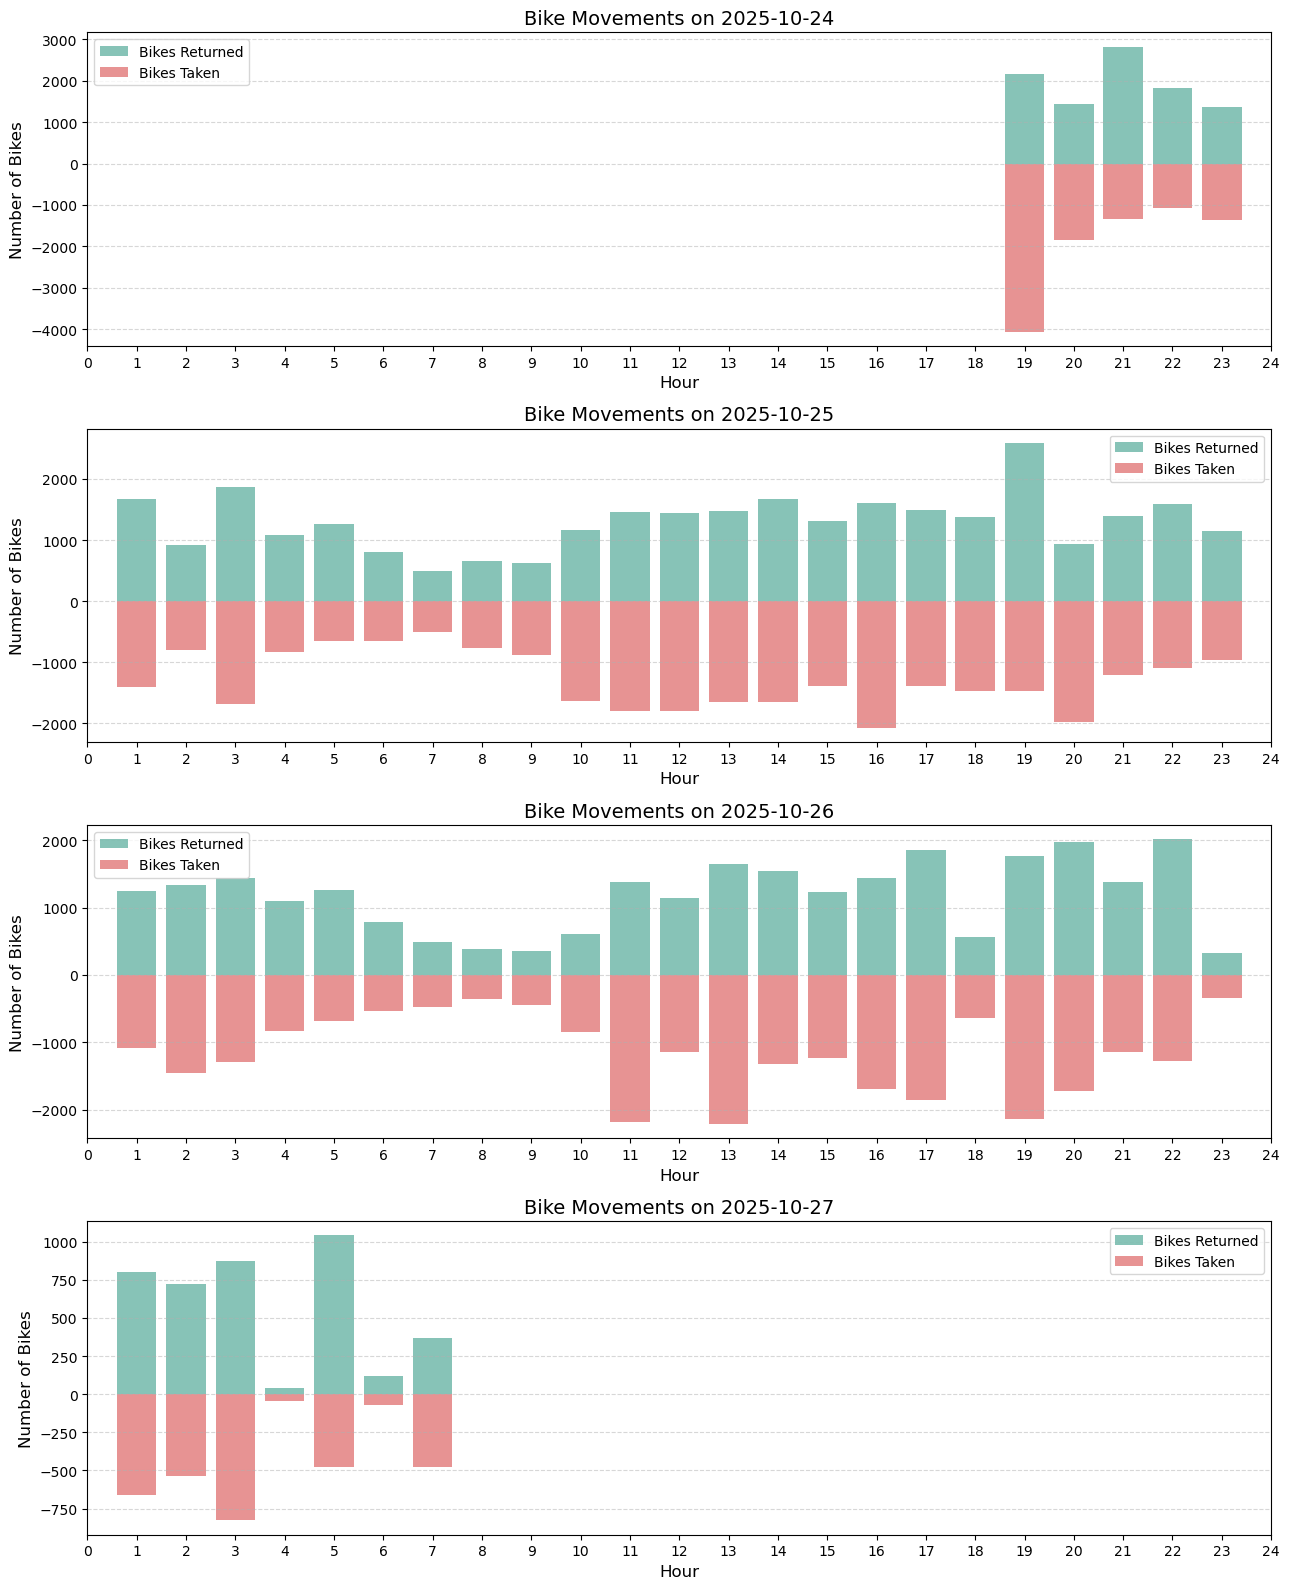

FileNotFoundError: [Errno 2] No such file or directory: '/System/Volumes/Data/home/yourusername/Documents/Work/Data Science/Projects/Velib/bike_movements.png'

In [70]:
# 1. Create figure and axis to subplotes

fig = plt.figure(figsize = (13,16))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)


# 2. Get the days from my data

hours = range(25) # x -axis
days = agg_hourly['date'].unique() 

for i,day in enumerate(days):
    # I accessed the day and need to pull the data of the day
    data_day = agg_hourly[agg_hourly['date'] == day ]
    data_day = data_day.set_index('hour') .reindex(hours,fill_value =0).reset_index()
    
    ax = [ax1,ax2,ax3,ax4][i] #access to the ax i 
    
    # Plot positive bars
    ax.bar(data_day['hour'], data_day['bikes_returned'] , color = '#5A9', label = 'Bikes Returned',alpha = 0.7)
    
    # Plot negative bars
    ax.bar(data_day['hour'], data_day['bikes_taken'] , color = '#D66', label = 'Bikes Taken', alpha = 0.7)
    
    # total movement
    ax.grid(axis='y', linestyle = '--' , alpha = 0.5)
    ax.set_title(f'Bike Movements on {day}', fontsize =14)
    ax.set_xlabel('Hour', fontsize =12)
    ax.set_ylabel('Number of Bikes' ,fontsize=12)
    ax.legend()
    
    ax.set_xlim(0,24)
    ax.set_xticks(hours)


# Avoid overlap and plot

fig.tight_layout()
plt.show()


fig.savefig('/Users/victorhugo/Documents/Work/Data Science/Projects/Velib/bike_movements.png', 
            bbox_inches='tight', dpi=300)

